In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/conways-reverse-game-of-life-2020/train.csv
/kaggle/input/conways-reverse-game-of-life-2020/test.csv
/kaggle/input/conways-reverse-game-of-life-2020/sample_submission.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
if __name__ == "__main__":
    training = pd.read_csv('/kaggle/input/conways-reverse-game-of-life-2020/train.csv')
    test = pd.read_csv('/kaggle/input/conways-reverse-game-of-life-2020/test.csv')

In [4]:
start_features = [f for f in training.columns if "start" in f]
stop_features = [f for f in test.columns if "stop" in f]
features_in = stop_features+["delta"]

Text(0.5, 1.0, 'Stop')

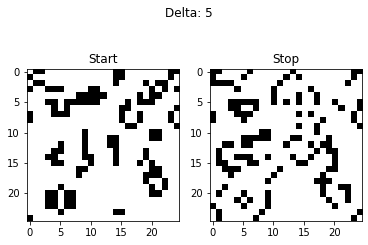

In [5]:
#Visualize sample
idx = 3

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f'Delta: {training.loc[idx, "delta"]}')
ax1.imshow(1-(training.loc[idx, start_features].values).reshape(25, 25), cmap="gray")
ax1.set_title("Start")
ax2.imshow(1-(training.loc[idx, stop_features].values).reshape(25, 25), cmap="gray")
ax2.set_title("Stop")

In [6]:
training = training.sample(frac=1).reset_index(drop=True) #shuffling the data

In [7]:
import re
def filter_string(str_arr, regex): 
    p = re.compile(regex)
    return [ s for s in str_arr if p.match(s) ]

In [8]:
start_column = filter_string(training.columns,'start')
stop_column = filter_string(training.columns,'stop')

In [9]:
X = training[start_column][:50000].to_numpy()
Y = training[stop_column][:50000].to_numpy()

In [10]:
#validation train split using stratified kfold.
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,shuffle=True,random_state= 42)


In [11]:
def convert_boardtomatrix(board):
    matrix = np.zeros(shape=[board.shape[0], board.shape[1]])
    for i in range(board.shape[0]):
        for j in range(board.shape[1]):
            # a represents the value of 8 neighbours
            a = []
            if i - 1 >= 0:
                a.append(1 if board[i - 1][j] == 1 else 0)
            if j - 1 >= 0:
                a.append(1 if board[i][j - 1] == 1 else 0)
            if i - 1 >= 0 and j - 1 >= 0:
                a.append(1 if board[i - 1][j - 1] == 1 else 0)
            if i + 1 < board.shape[0]:
                a.append(1 if board[i + 1][j] == 1 else 0)
            if j + 1 < board.shape[1]:
                a.append(1 if board[i][j + 1] == 1 else 0)
            if i + 1 < board.shape[0] and j + 1 < board.shape[1]:
                a.append(1 if board[i + 1][j + 1] == 1 else 0)
            if i - 1 >= 0 and j + 1 < board.shape[1]:
                a.append(1 if board[i - 1][j + 1] == 1 else 0)
            if i + 1 < board.shape[0] and j - 1 >= 0:
                a.append(1 if board[i + 1][j - 1] == 1 else 0)

            matrix[i][j] = np.sum(a)
    return matrix

In [12]:
#broadtomatrix
X_train = np.array([convert_boardtomatrix(tm.reshape([25,25]))for tm in X_train]).reshape([-1,25,25,1])
X_test = np.array([convert_boardtomatrix(tm.reshape([25,25]))for tm in X_test]).reshape([-1,25,25,1])


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential 

In [14]:
from keras.layers.convolutional import Conv2D
from keras.layers import Dense
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout,Flatten
from keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
import keras

In [16]:
img_height_rows = 25
img_width_cols = 25

In [17]:
im_shape = (img_height_rows,img_width_cols,1)

In [18]:
from tensorflow.keras import models, layers, losses

In [19]:
def Model_CNN():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (1, 1), activation='relu', input_shape=(25, 25, 1)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(625, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.compile(optimizer='SGD',loss='MSE',metrics=['accuracy'])
    return model

In [20]:
model = Model_CNN()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 64)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 625)               4000625   
_________________________________________________________________
dropout (Dropout)            (None, 625)               0         
Total params: 4,037,681
Trainable params: 4,037,681
Non-trainable params: 0
______________________________________________

In [21]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es = EarlyStopping(monitor='val_loss',patience=50)

In [22]:
history=model.fit(X_train,y_train,batch_size=32,epochs=200,verbose=1,callbacks=[es],validation_split=0.25,shuffle=True)

Epoch 1/200
821/821 [==============================] - 3s 4ms/step - loss: 0.2508 - accuracy: 0.0011 - val_loss: 0.1690 - val_accuracy: 0.0014
Epoch 2/200
821/821 [==============================] - 3s 4ms/step - loss: 0.1709 - accuracy: 0.0019 - val_loss: 0.1549 - val_accuracy: 0.0018
Epoch 3/200
821/821 [==============================] - 4s 4ms/step - loss: 0.1551 - accuracy: 0.0018 - val_loss: 0.1495 - val_accuracy: 0.0018
Epoch 4/200
821/821 [==============================] - 3s 4ms/step - loss: 0.1495 - accuracy: 0.0017 - val_loss: 0.1476 - val_accuracy: 0.0022
Epoch 5/200
821/821 [==============================] - 3s 4ms/step - loss: 0.1474 - accuracy: 0.0020 - val_loss: 0.1469 - val_accuracy: 0.0023
Epoch 6/200
821/821 [==============================] - 3s 4ms/step - loss: 0.1466 - accuracy: 0.0020 - val_loss: 0.1465 - val_accuracy: 0.0022
Epoch 7/200
821/821 [==============================] - 4s 4ms/step - loss: 0.1461 - accuracy: 0.0020 - val_loss: 0.1463 - val_accuracy: 0.0024

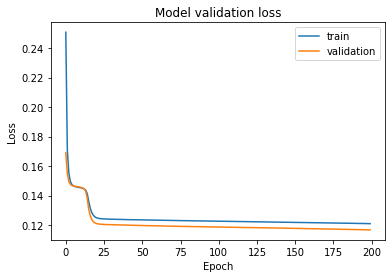

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','validation'], loc='upper right')
plt.show()

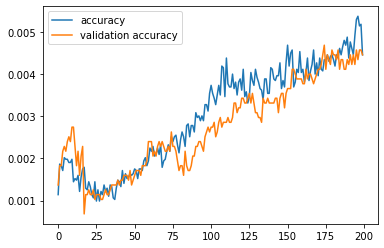

In [24]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.legend(loc='best')
plt.show()

In [25]:
%%time
training["pad"] = -1
test["pad"] = -1
INIT_COLS = [f"start_{i}" for i in range(625)]
STOP_COLS = [f"stop_{i}" for i in range(625)]

CPU times: user 4.13 ms, sys: 1 µs, total: 4.13 ms
Wall time: 3.59 ms


In [26]:
grid = test[STOP_COLS].values

In [27]:
import gc
sub = test[['id']].copy()
tp = pd.DataFrame(grid, columns=INIT_COLS)
sub = sub.join(tp)
del tp
gc.collect()

6637

In [28]:
sub.head()

,id,start_0,start_1,start_2,start_3,start_4,start_5,start_6,start_7,start_8,...,start_615,start_616,start_617,start_618,start_619,start_620,start_621,start_622,start_623,start_624
0,50000,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
1,50001,0,0,0,0,0,0,0,1,0,...,0,0,1,1,0,1,0,0,0,0
2,50002,0,1,0,0,1,0,0,0,0,...,1,1,0,0,0,0,1,0,1,0
3,50003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,50004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
sub.to_csv("submission.csv", index=False)

In [30]:
from keras.models import load_model
model.save('conway.h5')

In [31]:
predict = model.predict(X_test)
predict

array([[0.03160181, 0.03829009, 0.03678171, ..., 0.04187809, 0.03846163,
        0.07021987],
       [0.05422441, 0.06231201, 0.06489637, ..., 0.06977611, 0.06665205,
        0.04600007],
       [0.08988803, 0.07657872, 0.07150489, ..., 0.06585227, 0.0967559 ,
        0.08195002],
       ...,
       [0.20341207, 0.17213252, 0.20248757, ..., 0.20404015, 0.20700434,
        0.22293185],
       [0.10557017, 0.10562997, 0.09394077, ..., 0.13928194, 0.12897044,
        0.13100669],
       [0.22876696, 0.19582096, 0.23963653, ..., 0.23670816, 0.22476916,
        0.23300475]], dtype=float32)

In [32]:
submit_df = pd.DataFrame(index=test.index, columns=['start_' + str(i) for i in range(625)])